# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:

!pip install pyspark

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg,col,concat,lit,min,max,split,udf,last,when
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,LinearSVC
from pyspark.ml.feature import CountVectorizer,IDF,Normalizer,PCA,RegexTokenizer,StandardScaler,VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
import re
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
# create a Spark session
spark=SparkSession.builder\
      .master("local")\
      .appName("SparkifyProject")\
      .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df=spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
len(df.columns)

18

In [6]:
#To check the rows in dataframe
df.count()

286500

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#Convert into pandas dataframe for better understanding
df_pandas=df.toPandas()

In [9]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [10]:
#Let's have a look at the unique values of some columns
df_pandas['auth'].unique(),df_pandas['gender'].unique(),df_pandas['level'].unique(),df_pandas['page'].unique(),df_pandas['status'].unique()

(array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 array(['M', 'F', None], dtype=object),
 array(['paid', 'free'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]))

In [11]:
# Checking for null values of userids and sessionids
df_notnull = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_notnull.count()

286500

In [12]:
#Let's check for the values with empty userids and sessionids
df.filter(df.userId == '').count()

8346

In [13]:
df.filter(df.sessionId == '').count()

0

In [14]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')


In [15]:
#Last Check
df.filter(df.userId == '').count()

0

In [16]:
df_pandas=df.toPandas()

In [17]:
#Let's have a look at the unique values of some columns
df_pandas['auth'].unique(),df_pandas['gender'].unique(),df_pandas['level'].unique(),df_pandas['page'].unique(),df_pandas['status'].unique()

(array(['Logged In', 'Cancelled'], dtype=object),
 array(['M', 'F'], dtype=object),
 array(['paid', 'free'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]))

### Insight-1:
By removing the rows with invalid userId's & sessionId's, we arrive at the following insights:-
1. The 'auth' column has dropped two values Logged Out & Guest.
2. The 'page' column has dropped 'Login','Register','Submit Registration' values.

### Conclusion-1:
When we are dealing with the rows of empty userId , he/she is a 'Guest' and trying to 'Register' or 'Submit Registration'.
When we are dealing with the rows of empty sessionId , he/she has 'Logged Out' and trying to 'Login'.
As we removed both the rows, the following rows associated with those values are removed.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
#Number of unique userId's in dataset
df.select("userId").dropDuplicates().count()


225

In [19]:
# Create a column 'churn' to use as label for the model
churn=udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())
df=df.withColumn("churn",churn(df.page))

In [20]:
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [21]:
df_pandas=df.toPandas()

In [22]:
df.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0

### Let's explore the behaviour of users who stayed vs users who churned.

In [23]:
#How many users are remaining and churned(cancelled)
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [24]:
#How many Users based on gender are remaining and churned(cancelled)
df.dropDuplicates(['userId','gender']).groupby(['churn','gender']).count().show()


+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [25]:
#How many Users based on level are remaining and churned(cancelled)
df.dropDuplicates(['userId','level']).groupby(['churn','level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



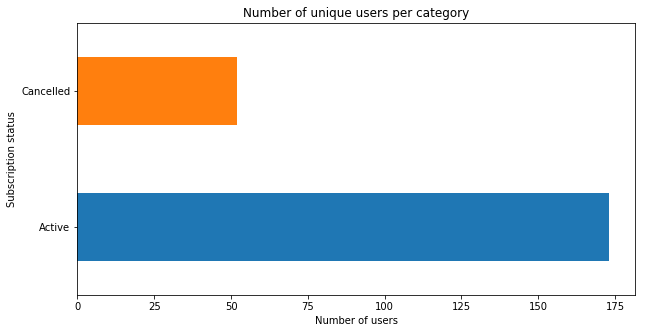

In [26]:
#Plot some visualisations based on the behaviour of users who stayed vs users who churned. 
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    '''
    Plot a visualisation for frequency of users v/s subscription status
    Input(s):
    subset- Column name for dropping duplicated data
    group- Column name based on which grouping is carried out
    labels- Label for output data
    x_title-Titlte for x axis
    y_title-Title for y axis.
    
    Output: Returns a 1D visualisation based on the inputs.
    '''
    ax = df_pandas.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(10,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);
   
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

### Conclusion-2:
The number of unique users are more active than cancelled users.

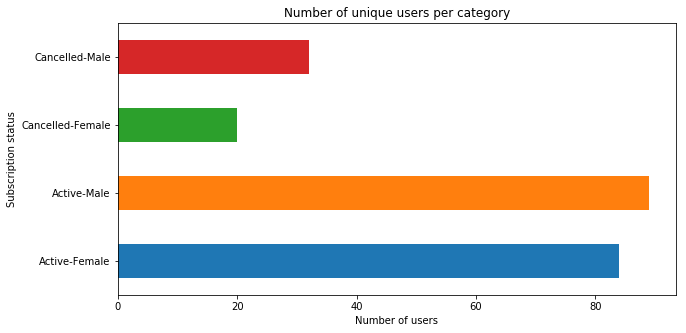

In [27]:
plot_frequency(['userId','gender'], ['churn','gender'], ['Active-Female', 'Active-Male','Cancelled-Female','Cancelled-Male'])

### Conclusion 3:
Males are slightly predominant than females in both active and cancelled subscriptions.

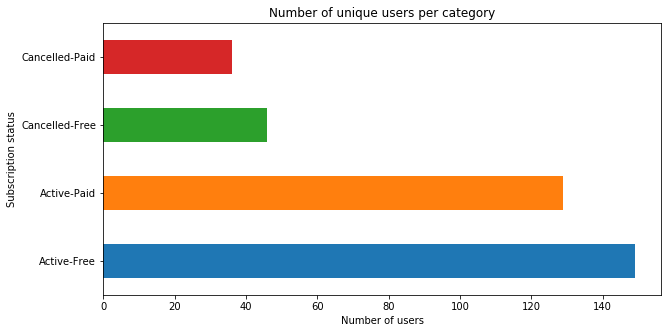

In [28]:
plot_frequency(['userId','level'], ['churn','level'], ['Active-Free', 'Active-Paid','Cancelled-Free','Cancelled-Paid'])

### Conclusion 4:
Most of the cancelled subscriptions are from 'free' users and the same holds true for active subscriptions.

In [29]:
df_page = df.select(["page","churn"]).groupby([ "page","churn"]).count().sort("page")

In [30]:
df_page=df_page[df_page["page"]!="NextSong"]

In [31]:
df_page_pandas=df_page.toPandas()

In [32]:
df_page_pandas.head()

,page,churn,count
0,About,1,56
1,About,0,439
2,Add Friend,1,636
3,Add Friend,0,3641
4,Add to Playlist,1,1038


In [33]:
import seaborn as sns

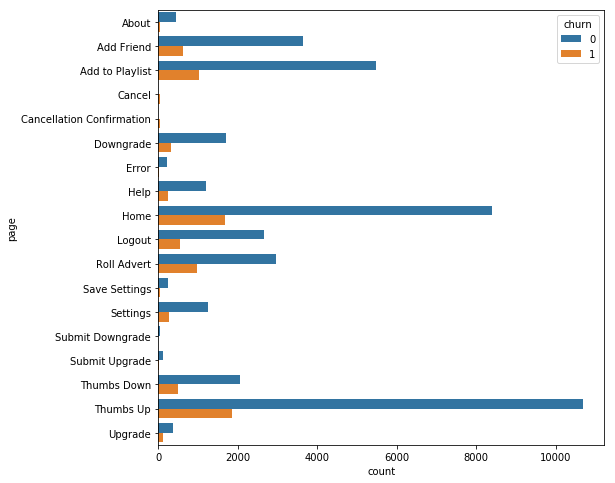

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="count",y="page", hue="churn", data=df_page_pandas,ax=ax);


### Conclusion 5:
On the page list, the number of active users are way farther than cancelled users except for 'Cancel' and 'Cancellation Confirmation' pages. Out of all pages, the highest number of active users are visiting 'Thumbs Up','Home','Add to playlist','Add to friend' pages.

In [35]:
#Exploring how much of a specific action they experienced per a certain time unit 
# Definig user functions to get hour, day, month from timestamp ts

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)


In [36]:
# Adding them as columns
columns={"hour":get_hour,"day":get_day,"month":get_month}
for label,col in columns.items():
    df=df.withColumn(label,col(df.ts))

In [37]:
df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|  12|  8|   10|
|Francesca Battist..

In [38]:
# Count the number of songs in each hour of day and store it in a pandas dataframe
songs_in_hour = df.select(["churn","hour"]).filter(df.page == 'NextSong').groupby(["churn","hour"]).count().orderBy(df.hour.cast("int"))

In [39]:
songs_in_hour.show()

+-----+----+-----+
|churn|hour|count|
+-----+----+-----+
|    1|   0| 1535|
|    0|   0| 7527|
|    0|   1| 7035|
|    1|   1| 1353|
|    0|   2| 7014|
|    1|   2| 1322|
|    1|   3| 1292|
|    0|   3| 7063|
|    1|   4| 1233|
|    0|   4| 6914|
|    1|   5| 1218|
|    0|   5| 6960|
|    1|   6| 1218|
|    0|   6| 6836|
|    0|   7| 6873|
|    1|   7| 1218|
|    1|   8| 1230|
|    0|   8| 7023|
|    0|   9| 7268|
|    1|   9| 1230|
+-----+----+-----+
only showing top 20 rows



In [40]:
songs_in_hour_pd=songs_in_hour.toPandas()

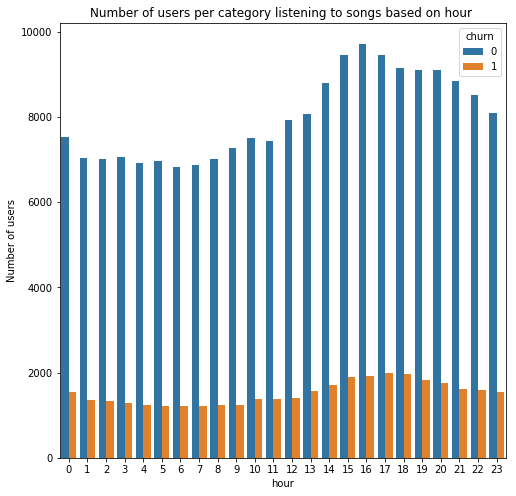

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="hour",y="count", hue="churn", data=songs_in_hour_pd,ax=ax,order=list(map(lambda x: str(x),range(24))));
plt.ylabel("Number of users")
plt.title("Number of users per category listening to songs based on hour ");

### Conclusion 6:
Most of the users are listening to the songs between 15th and 18th hours.

In [42]:
# Count the number of songs in each day of month and store it in a pandas dataframe
songs_in_day = df.select(["churn","day"]).filter(df.page == 'NextSong').groupby(["churn","day"]).count().orderBy(df.day.cast("int"))

In [43]:
songs_in_day.show()

+-----+---+-----+
|churn|day|count|
+-----+---+-----+
|    0|  1| 7575|
|    1|  1| 1612|
|    0|  2| 7668|
|    1|  2| 1978|
|    0|  3| 4869|
|    1|  3| 1542|
|    1|  4| 1262|
|    0|  4| 4467|
|    0|  5| 5267|
|    1|  5| 1599|
|    1|  6|  790|
|    0|  6| 6006|
|    0|  7| 4906|
|    1|  7| 1011|
|    0|  8| 5793|
|    1|  8| 1597|
|    1|  9| 2050|
|    0|  9| 7167|
|    1| 10| 1883|
|    0| 10| 5908|
+-----+---+-----+
only showing top 20 rows



In [44]:
songs_in_day_pd=songs_in_day.toPandas()

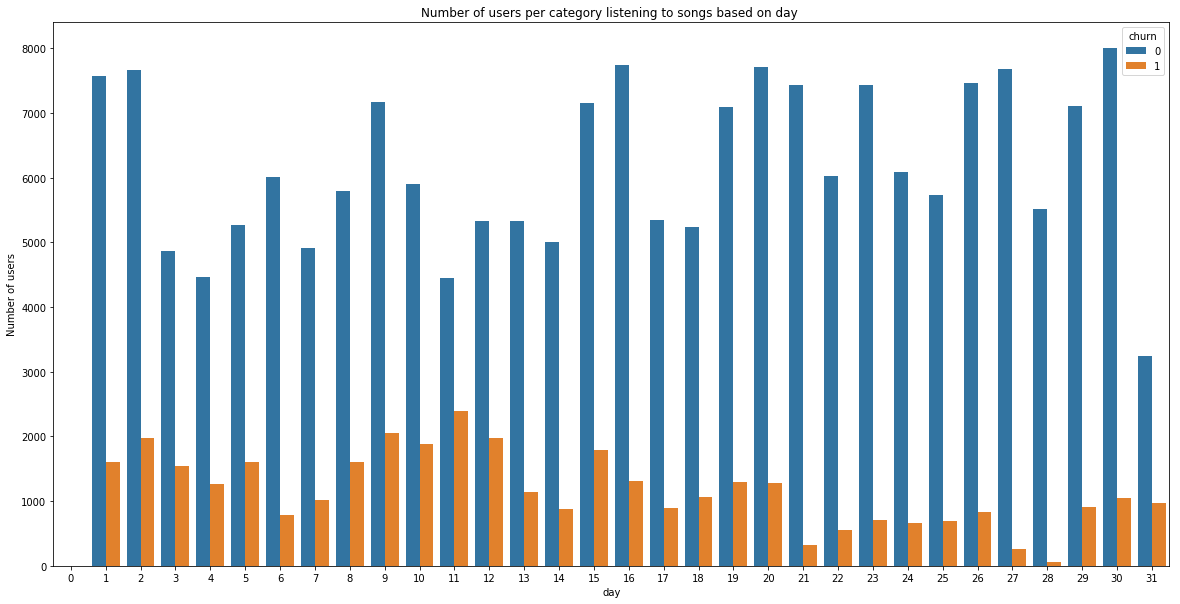

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot( x="day",y="count", hue="churn", data=songs_in_day_pd,ax=ax,order=list(map(lambda x: str(x),range(32))));
plt.ylabel("Number of users")
plt.title("Number of users per category listening to songs based on day ");

### Conclusion 7:
The no of users listening to the songs are increasing and decreasing , no particular trend is observed.

In [46]:
# Count the number of songs in each month of year and store it in a pandas dataframe
songs_in_month = df.select(["churn","month"]).filter(df.page == 'NextSong').groupby(["churn","month"]).count().orderBy(df.month.cast("int"))

In [47]:
songs_in_month_pd=songs_in_month.toPandas()

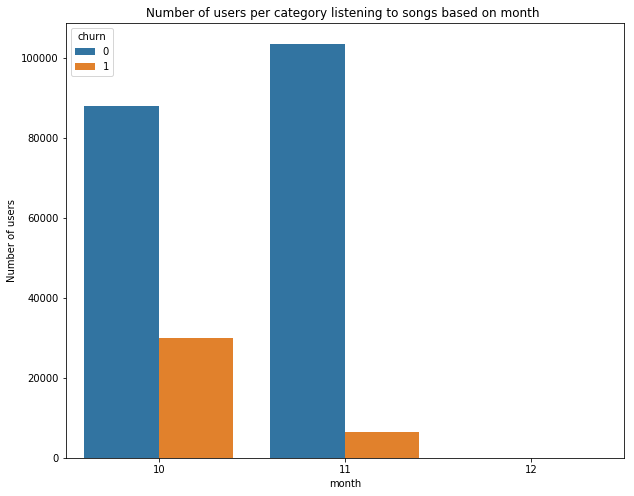

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot( x="month",y="count", hue="churn", data=songs_in_month_pd,ax=ax);
plt.ylabel("Number of users")
plt.title("Number of users per category listening to songs based on month ");

### Conclusion 8:
As the data is limited to 2 months,There is not much data to explore about the number of users listening to songs in a particular month of the year.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### We will extract the following features to help create the model:

1) Total no of songs listened

2) Gender

3) Paid or Free users

4) Average songs played per session

5) Number of Thumbs up

6) Number of Thumbs down

7) Number of songs added to the playlist

8) Total number of friends

9) Churn(target)

In [49]:
features=[]

### 1) Total no of songs listened

In [50]:
df_songs_listened=df.select(['userId','page']).where(df.page=="NextSong").groupby(['userId']).count().withColumnRenamed('count','no_of_songs')

In [51]:
df_songs_listened.show()

+------+-----------+
|userId|no_of_songs|
+------+-----------+
|100010|        275|
|200002|        387|
|   125|          8|
|    51|       2111|
|   124|       4079|
|     7|        150|
|    54|       2841|
|    15|       1914|
|   155|        820|
|   132|       1928|
|   154|         84|
|100014|        257|
|   101|       1797|
|    11|        647|
|   138|       2070|
|300017|       3632|
|    29|       3028|
|    69|       1125|
|100021|        230|
|    42|       3573|
+------+-----------+
only showing top 20 rows



In [52]:
features.append(df_songs_listened)

### 2) Gender

In [53]:
# Set Male to 0 and Female to 1
get_gender=udf(lambda x:1 if x=='F' else 0,IntegerType())

In [54]:
df=df.withColumn('isfemale',get_gender(df.gender))

In [55]:
df_gender=df.dropDuplicates(['userId']).select(['userId', 'isfemale']).groupby('userId') .agg(max('isfemale')).withColumnRenamed('max(isfemale)','is_female')

In [56]:
df_gender.show()

+------+---------+
|userId|is_female|
+------+---------+
|100010|        1|
|200002|        0|
|   125|        0|
|    51|        0|
|   124|        1|
|     7|        0|
|    54|        1|
|    15|        0|
|   155|        1|
|   132|        1|
|   154|        1|
|100014|        0|
|   101|        0|
|    11|        1|
|   138|        0|
|300017|        1|
|    29|        0|
|    69|        1|
|100021|        0|
|    42|        1|
+------+---------+
only showing top 20 rows



In [57]:
features.append(df_gender)

### 3) Paid or Free users

In [58]:
# Set paid users to 1 and free users to 0

get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
# Apply the udf to create a new numeric "level" column
df = df.withColumn('isPaid', get_level(df.level))

df_level = df.dropDuplicates(['userId']).select(['userId', 'isPaid']) \
                                                                .groupby('userId').agg(max('isPaid')) \
                                                                .withColumnRenamed('max(isPaid)', 'isPaid')


In [59]:
df_level.show()

+------+------+
|userId|isPaid|
+------+------+
|100010|     0|
|200002|     0|
|   125|     0|
|    51|     1|
|   124|     1|
|     7|     0|
|    54|     1|
|    15|     1|
|   155|     0|
|   132|     0|
|   154|     0|
|100014|     1|
|   101|     0|
|    11|     0|
|   138|     0|
|300017|     1|
|    29|     0|
|    69|     0|
|100021|     0|
|    42|     0|
+------+------+
only showing top 20 rows



In [60]:
features.append(df_level)

### 4) Average songs played per session

In [61]:
df_songs_per_session=df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count()

In [62]:
df_avg_songs_per_session=df_songs_per_session.groupby(['userId']).agg({'count': 'avg'})

In [63]:
df_avg_songs_per_session.show()

+------+------------------+
|userId|        avg(count)|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [64]:
df_avg_songs_per_session=df_avg_songs_per_session.withColumnRenamed('avg(count)', 'avg_songs_per_session')

In [65]:
df_avg_songs_per_session.show(5)

+------+---------------------+
|userId|avg_songs_per_session|
+------+---------------------+
|100010|   39.285714285714285|
|200002|                 64.5|
|   125|                  8.0|
|    51|                211.1|
|   124|   145.67857142857142|
+------+---------------------+
only showing top 5 rows



In [66]:
features.append(df_avg_songs_per_session)

### 5) Number of Thumbs up

In [67]:
df_thumbs_up=df.select(['userId','page']).where(df.page=="Thumbs Up").groupby(['userId']).count().withColumnRenamed('count','no_of_thumbsup')

In [68]:
df_thumbs_up.show()

+------+--------------+
|userId|no_of_thumbsup|
+------+--------------+
|100010|            17|
|200002|            21|
|    51|           100|
|   124|           171|
|     7|             7|
|    54|           163|
|    15|            81|
|   155|            58|
|   132|            96|
|   154|            11|
|100014|            17|
|   101|            86|
|    11|            40|
|   138|            95|
|300017|           303|
|    29|           154|
|    69|            72|
|100021|            11|
|    42|           166|
|   112|             9|
+------+--------------+
only showing top 20 rows



In [69]:
features.append(df_thumbs_up)

### 6) Number of Thumbs down

In [70]:
df_thumbs_down=df.select(['userId','page']).where(df.page=="Thumbs Down").groupby(['userId']).count().withColumnRenamed('count','no_of_thumbsdown')

In [71]:
df_thumbs_down.show()

+------+----------------+
|userId|no_of_thumbsdown|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
|    15|              14|
|    54|              29|
|   155|               3|
|   132|              17|
|100014|               3|
|   101|              16|
|    11|               9|
|   138|              24|
|300017|              28|
|    29|              22|
|    69|               9|
|100021|               5|
|    42|              25|
|   112|               3|
|    73|               7|
+------+----------------+
only showing top 20 rows



In [72]:
features.append(df_thumbs_down)

### 7) Number of songs added to the playlist

In [73]:
df_songs_playlist=df.select(['userId','page']).where(df.page=="Add to Playlist").groupby(['userId']).count().withColumnRenamed('count','songs_added_to_playlist')

In [74]:
df_songs_playlist.show()

+------+-----------------------+
|userId|songs_added_to_playlist|
+------+-----------------------+
|100010|                      7|
|200002|                      8|
|    51|                     52|
|   124|                    118|
|     7|                      5|
|    15|                     59|
|    54|                     72|
|   155|                     24|
|   132|                     38|
|   154|                      1|
|100014|                      7|
|   101|                     61|
|    11|                     20|
|   138|                     67|
|300017|                    113|
|    29|                     89|
|    69|                     33|
|100021|                      7|
|    42|                    104|
|   112|                      7|
+------+-----------------------+
only showing top 20 rows



In [75]:
features.append(df_songs_playlist)

### 8) Total number of friends

In [76]:
df_friends=df.select(['userId','page']).where(df.page=="Add Friend").groupby(['userId']).count().withColumnRenamed('count','Friends')

In [77]:
df_friends.show()

+------+-------+
|userId|Friends|
+------+-------+
|100010|      4|
|200002|      4|
|    51|     28|
|   124|     74|
|     7|      1|
|    54|     33|
|    15|     31|
|   155|     11|
|   132|     41|
|   154|      3|
|100014|      6|
|   101|     29|
|    11|      6|
|   138|     41|
|300017|     63|
|    29|     47|
|    69|     12|
|100021|      7|
|    42|     52|
|   112|      7|
+------+-------+
only showing top 20 rows



In [78]:
features.append(df_friends)

### 9) Churn(target)

In [79]:
df_churn=df.select('userId', 'churn').dropDuplicates()

In [80]:
df_churn.show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [81]:
features.append(df_churn)

In [82]:
print(features)

[DataFrame[userId: string, no_of_songs: bigint], DataFrame[userId: string, is_female: int], DataFrame[userId: string, isPaid: int], DataFrame[userId: string, avg_songs_per_session: double], DataFrame[userId: string, no_of_thumbsup: bigint], DataFrame[userId: string, no_of_thumbsdown: bigint], DataFrame[userId: string, songs_added_to_playlist: bigint], DataFrame[userId: string, Friends: bigint], DataFrame[userId: string, churn: bigint]]


In [83]:
df_final = df_songs_listened

def merging_dataframes(df_1,df_2):
    '''  
    INPUT: 
    df_1,df_2 - dataframes to be merged
    
    OUTPUT: 
    merged_df - merged dataframe
    
    Description: 
    Join dataframes
    '''
    
    merged_df = df_2.join(df_1, on=['userId'], how='left')
    
    return merged_df

for feature in features[1:]:
    df_final = merging_dataframes(df_final, feature)

# fill nans
df_final = df_final.na.fill(0).drop('max(isfemale)','totalfriends')
df_final.show(5)

+------+-----+-------+-----------------------+----------------+--------------+---------------------+------+---------+-----------+
|userId|churn|Friends|songs_added_to_playlist|no_of_thumbsdown|no_of_thumbsup|avg_songs_per_session|isPaid|is_female|no_of_songs|
+------+-----+-------+-----------------------+----------------+--------------+---------------------+------+---------+-----------+
|100010|    0|      4|                      7|               5|            17|   39.285714285714285|     0|        1|        275|
|200002|    0|      4|                      8|               6|            21|                 64.5|     0|        0|        387|
|   125|    1|      0|                      0|               0|             0|                  0.0|     0|        0|          0|
|   124|    0|     74|                    118|              41|           171|   145.67857142857142|     1|        1|       4079|
|    51|    1|     28|                     52|              21|           100|            

In [84]:
df_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- Friends: long (nullable = true)
 |-- songs_added_to_playlist: long (nullable = true)
 |-- no_of_thumbsdown: long (nullable = true)
 |-- no_of_thumbsup: long (nullable = true)
 |-- avg_songs_per_session: double (nullable = false)
 |-- isPaid: integer (nullable = true)
 |-- is_female: integer (nullable = true)
 |-- no_of_songs: long (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [85]:
df_final.columns

['userId',
 'churn',
 'Friends',
 'songs_added_to_playlist',
 'no_of_thumbsdown',
 'no_of_thumbsup',
 'avg_songs_per_session',
 'isPaid',
 'is_female',
 'no_of_songs']

In [86]:
# Let's use vector Assembler and Standard Scaler to convert our numeric columns to vectors for ML modelling.
assembler= VectorAssembler(inputCols=['Friends',
 'songs_added_to_playlist',
 'no_of_thumbsdown',
 'no_of_thumbsup',
 'avg_songs_per_session',
 'isPaid',
 'is_female',
 'no_of_songs'],outputCol='Num_of_features')
df_final=assembler.transform(df_final)

In [87]:
scaler=StandardScaler(inputCol='Num_of_features',outputCol='scaled_features',withStd=True,withMean=True)

In [88]:
scalerModel=scaler.fit(df_final)

In [89]:
df_final=scalerModel.transform(df_final)

In [90]:
df_final=df_final.select('churn','scaled_features')

In [91]:
df_final.show()

+-----+--------------------+
|churn|     scaled_features|
+-----+--------------------+
|    0|[-0.7292340618073...|
|    0|[-0.7292340618073...|
|    1|[-0.9235813095498...|
|    0|[2.67184277368726...|
|    1|[0.43684942464797...|
|    0|[-0.8749944976142...|
|    0|[0.58260986045488...|
|    1|[0.67978348432615...|
|    0|[-0.3891263782578...|
|    1|[-0.6320604379360...|
|    0|[1.06847797981124...|
|    0|[-0.7778208737429...|
|    1|[0.48543623658360...|
|    0|[-0.6320604379360...|
|    0|[1.06847797981124...|
|    0|[2.13738784239526...|
|    1|[-0.5834736260004...|
|    1|[1.35999885142507...|
|    0|[-0.3405395663222...|
|    0|[-0.5834736260004...|
+-----+--------------------+
only showing top 20 rows



In [92]:
df_final.count()

225

In [93]:
# Split the train and test datasets
train,test=df_final.randomSplit([0.8,0.2],seed=42)

### Metrics implemented

 1. Accuracy of the various models, tuning parameters as necessary.
 2. Since the churned users are a fairly small subset, I am using F1 score as the metric to optimize.

### Define a function for printing results and final report

In [94]:
def print_results(result_name,model_name,start_time,end_time):
    ''' 
    The functions prints the results of some performace metrics and training times.
    
    INPUT-
    result_name: Name in which result is stored
    model_name: Name of classification model used
    start_time: Start of the trainig time
    end_time:End of the training time
    
    OUTPUT-
    List of results'''
    
    evaluator=MulticlassClassificationEvaluator()
    evaluator.setLabelCol('churn')
    F1score= evaluator.evaluate(result_name,{evaluator.metricName: "f1"})
    Accuracy=evaluator.evaluate(result_name,{evaluator.metricName: "accuracy"})
    time = (end_time - start_time)/60
    
    result = [model_name,F1score,Accuracy,time]
    
    print('{} performance metrics:'.format(model_name))
    print('F-1 Score: {}'.format(round(F1score,3)))
    print('Accuracy: {}'.format(round(Accuracy,3)))
    print('Total training time: {} minutes'.format(round(time,2)))
    
    return result

In [95]:
def final_report(result_list):
    '''
    The function aggregates and prints results of models
    INPUT:
    result_list : list
    
    OUTPUT: None
   
    '''
    print(result_list[0])
    print('F1 Score: {}'.format(round(result_list[1],3)))
    print('Accuracy: {}'.format(round(result_list[2],3)))
    print('Total training time: {} minutes'.format(round(result_list[3],2)))
    
    print()

## Train the data using different ML models

Let's explore the following classification models:
1. Logistic regression model
2. Random Forest Classifier
3. Support Vector Machine


### Logistic Regression model

In [96]:

lr = LogisticRegression(maxIter=10, labelCol='churn', featuresCol='scaled_features')

lr_start = time.time()
lr_model = lr.fit(train)
lr_end = time.time()

In [97]:
lr_results = lr_model.transform(test)

lr_report = print_results(lr_results, 'Logistic Regression', lr_start, lr_end)



Logistic Regression performance metrics:
F-1 Score: 0.584
Accuracy: 0.706
Total training time: 1.41 minutes


### Hyperparameter tuning

In [98]:
pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
    numFolds=3)

lr_start = time.time()
lr_tunemodel = crossval.fit(train)
lr_end = time.time()

In [99]:
lr_tuned_results = lr_tunemodel.transform(test)

lr_tuned_report = print_results(lr_tuned_results, 'Logistic Regression', lr_start, lr_end)

best_param = list(lr_tunemodel.getEstimatorParamMaps()[np.argmax(lr_tunemodel.avgMetrics)].values())
print('Best regression parameter is {}'.format(best_param[0]))

Logistic Regression performance metrics:
F-1 Score: 0.584
Accuracy: 0.706
Total training time: 8.8 minutes
Best regression parameter is 0.01


### Random Forest Classifier

In [100]:
rf = RandomForestClassifier(labelCol='churn', featuresCol='scaled_features', seed = 42)
rf_start = time.time()
rf_model = rf.fit(train)
rf_end = time.time()

In [101]:
rf_results = rf_model.transform(test)

rf_report = print_results(rf_results, 'Random Forest Classifier', rf_start, rf_end)

Random Forest Classifier performance metrics:
F-1 Score: 0.703
Accuracy: 0.765
Total training time: 1.68 minutes


### Hyperparameter Tuning

In [102]:
pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20])
             .addGrid(rf.maxDepth, [10,20])
             .build())

crossval_rf = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
    numFolds=3)

rf_start = time.time()
rf_tunemodel = crossval_rf.fit(train)
rf_end = time.time()

In [103]:
rf_tuned_results = rf_tunemodel.transform(test)

rf_tuned_report = print_results(rf_tuned_results, 'Random Forest Classifier', rf_start, rf_end)

best_param = list(rf_tunemodel.getEstimatorParamMaps()[np.argmax(rf_tunemodel.avgMetrics)].values())
print('Best number of trees {}, best depth {}'.format(best_param[0], best_param[1]))

Random Forest Classifier performance metrics:
F-1 Score: 0.629
Accuracy: 0.706
Total training time: 13.87 minutes
Best number of trees 10, best depth 10


### Support Vector Machine

In [104]:
svc = LinearSVC(labelCol='churn', featuresCol='scaled_features')
svc_start = time.time()
svc_model = svc.fit(train)
svc_end = time.time()

In [105]:
svc_results = svc_model.transform(test)

svc_report = print_results(svc_results, 'Support Vector Classifier', svc_start, svc_end)

Support Vector Classifier performance metrics:
F-1 Score: 0.584
Accuracy: 0.706
Total training time: 34.87 minutes


In [106]:
# Hyperparameter tuning
pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [5,10])
                 .build())

crossval_svc = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol='churn'),
    numFolds=3)

svc_start = time.time()
svc_tunemodel = crossval_svc.fit(train)
svc_end = time.time()

In [107]:
svc_tuned_results =svc_tunemodel.transform(test)

svc_tuned_report = print_results(svc_tuned_results, 'Support Vector Classifier', svc_start, svc_end)

best_param = list(svc_tunemodel.getEstimatorParamMaps()[np.argmax(svc_tunemodel.avgMetrics)].values())
print('Max no of Iterations:{}'.format(best_param[0]))

Support Vector Classifier performance metrics:
F-1 Score: 0.584
Accuracy: 0.706
Total training time: 9.61 minutes
Max no of Iterations:5


### Reports

In [108]:
result_list = [lr_report, rf_report, svc_report]

for res in result_list:
    final_report(res)

Logistic Regression
F1 Score: 0.584
Accuracy: 0.706
Total training time: 1.41 minutes

Random Forest Classifier
F1 Score: 0.703
Accuracy: 0.765
Total training time: 1.68 minutes

Support Vector Classifier
F1 Score: 0.584
Accuracy: 0.706
Total training time: 34.87 minutes



In [109]:
finetuned_result_list = [lr_tuned_report, rf_tuned_report, svc_tuned_report]

for tune_res in finetuned_result_list:
    final_report(tune_res)

Logistic Regression
F1 Score: 0.584
Accuracy: 0.706
Total training time: 8.8 minutes

Random Forest Classifier
F1 Score: 0.629
Accuracy: 0.706
Total training time: 13.87 minutes

Support Vector Classifier
F1 Score: 0.584
Accuracy: 0.706
Total training time: 9.61 minutes



# Final Steps


## Conclusion

1.Out of three ML models, Random Forest Classifier proves to be best model both in terms of F1score and accuracy.

2.Cross validation and hyperparameter tuning doesn't make much difference in output since the test dataset is a small subset of data.

3.With the tuning, parameters of Random Forest Classifier are best number of trees-10 and max depth of 10 best fit the model.


### Links for reference


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html
https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.MulticlassClassificationEvaluator.html
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html#pyspark.ml.classification.RandomForestClassifier.numTrees
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LinearSVC.html